In [1]:
import pandas as pd
import numpy as np
import copy
import datetime
import time

/Users/annacjacobson/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
file = './TestData/eNY-7759.rttm'

### RTTM to Dataframe

In [3]:
# Step 1: Load the .rttm into a dataframe
def DfFromRttm(rttm):
    """ Given an RTTM file, parses it into a Pandas DataFrame.
    """
    df = pd.read_csv(rttm,
                     sep=' ',
                     names=['task','inputFile','one','start','duration',
                     'NA_1','NA_2','class','NA_3', 'NA_4'])    
    
    # Drop the columns we don't care about from a base RTTM
    vizframe = copy.deepcopy(df) \
        .drop(
        columns=[
            'task',
            'inputFile',
            'one',
            'NA_1',
            'NA_2',
            'NA_3',
            'NA_4'])
    
    return vizframe

## Audiozation Data

In [4]:
def RttmToUtteranceIndexedSpeakerActivity(df, outfile=None):
    """ Given an RTTM input file, generate a dataframe structured
        to support a visualization of type 'Speaker Activity' and optionally
        export to a csv located at {outfile}

        df = Pandas DataFrame containing a standard .rttm file
        outfile = destination for exported CSV (path, filename, extension)
    """

    # Check whether an outfile has been defined
    if outfile is not None:
        export = True
    else: 
        export = False

    # Drop the columns we don't care about from a base RTTM
    vizframe = copy.deepcopy(df) 

    # Rename columns for our viz's purposes
    vizframe = vizframe.rename(columns={
        'start': 'START',
        'duration': 'DUR',
        'class': 'LABEL'
    })

    # Remap the model classes for this viz's purposes
    vizframe['LABEL'] = vizframe['LABEL'].map({
        'KCHI': 'CHILD',
        'CHI': 'CHILD',
        'FEM': 'ADULT',
        'MAL': 'ADULT'
    })

    # Filter the dataframe to just the 'clean' (non-'SPEECH') classes
    vizframe = vizframe[vizframe['LABEL'].isin(['CHILD', 'ADULT'])]
    vizframe['LABEL_NUM'] = vizframe['LABEL'] \
        .apply(lambda x: 1 if x == 'CHILD'
               else (-1 if x == 'ADULT' else NaN))
    vizframe['DUR_TRANS'] = vizframe['LABEL_NUM'] * vizframe['DUR']
    vizframe['COUNT'] = 1

    if export:
        vizframe.to_csv(outfile)

    return vizframe

In [5]:
RttmToUtteranceIndexedSpeakerActivity(DfFromRttm(file), outfile=None)

,START,DUR,LABEL,LABEL_NUM,DUR_TRANS,COUNT
1,6.198,0.813,CHILD,1,0.813,1
2,7.773,0.145,CHILD,1,0.145,1
3,9.560,0.380,ADULT,-1,-0.380,1
4,10.694,0.240,CHILD,1,0.240,1
5,12.565,1.787,ADULT,-1,-1.787,1
...,...,...,...,...,...,...
143,235.567,3.714,ADULT,-1,-3.714,1
144,238.321,0.120,ADULT,-1,-0.120,1
145,238.641,0.125,ADULT,-1,-0.125,1
146,238.888,0.351,CHILD,1,0.351,1


## Time-Indexed Dataframe

In [6]:
## Identify the latest timestamp we need.
def GetLatestTimestampNeeded(input_df, verbose=True):
    """ Given an RTTM-derived dataframe,
        extract the last timestamp we'll need
        as a scalar. It will be the maximum value of
        the `start` + `duration` columns.
    """
    input_df['end_time'] = input_df['start'] + input_df['duration']
    end_row = input_df['end_time'].idxmax()
    latest_timestamp = input_df.at[end_row,'start'] + input_df.at[end_row,'duration']
    if verbose:
        print(f'''
        >> This DF has data that runs until {latest_timestamp}.
        >> That value was found at row {end_row} and is the sum of
           {input_df.at[end_row, 'start']} and {input_df.at[end_row, 'duration']}
        ''')
    return latest_timestamp

In [7]:
## Create 100 millisecond index.
def Make100MillisecondIntegerIndexedDf(
        start,
        duration,
        colname='value',
        colvalue='',
        decimals=2,
        verbose=False):
    """ Create an integer-indexed dataframe covering a 
            {duration} from
            {start} having a single column with the name
            {colname} that contains a default value of
            {colvalue} for that named column.
        By default it runs quietly rather than {verbose}.
    """

    if verbose:
        print(f' >>> From [{start}] for [{duration}] seconds' \
              f' until [{start+duration}] the col [{colname}]' \
              f' will contain the value [{colvalue}]')
    
    # Create a range between the start and stop
    rng = pd.RangeIndex(start = int(round(start, decimals)*10),
                        stop  = int(round(start+duration, decimals)*10),
                        step  = 1)
    
    # Turn that series into a DataFrame and rename the index for clarity
    df = pd.Series(colvalue, index=rng).to_frame(name=colname)
    df.index.name=f'100millisecond_ints'
    if verbose:
        print(df.head(3), df.tail(3))
    return df

In [8]:
## Subset by label.
def SubsetDfByLabel(df, column_list, key_col, value):
    """ Given a dataframe {df}, return the subset
        of the dataframe defined by {column_list}
        containing {value} in the {key_col} column
    """
    return df[df[key_col] == value][[x for x in column_list]]

In [9]:
# This is to make our lives easier later
ny_7759 = DfFromRttm(file)
ny_7759_bak = copy.deepcopy(ny_7759)

In [10]:
# This is to make our lives easier later
ny_0287 = DfFromRttm(file)
ny_0287_bak = copy.deepcopy(ny_0287)

In [11]:
def BuildOneHotEncodedDf(
    input_df,
    label_list=[],
    verbose=True
    ):
    """ Given an RTTM-generated DataFrame, generate a DF containing
        all of the labels of interest in one-hot encoded format
        against an integer-indexed DF representing milliseconds from
        the beginning of the recording
    """
    
    max_seconds_needed = GetLatestTimestampNeeded(input_df)
    if verbose:
        print(f'max_seconds_needed is equal to {max_seconds_needed}')

    outer_df = Make100MillisecondIntegerIndexedDf(
                start      = 0,
                duration   = max_seconds_needed,
                colname    = 'base_col',
                colvalue   = np.nan,
                decimals   = 2,
                verbose    = True)

    if verbose:
        print(f'The outer_df frame will contain {outer_df.shape[0]} records.')
    
    # Loop through labels, subsetting the original DF so
    # we can merge it back into the main outer DF
    for label in label_list:
        print(f'>>> Processing label: {label}\n')

        if label not in input_df['class'].unique():
            print(f'Label {label} not found in this dataset')
            label_base_df = pd.DataFrame(columns=[label])
            continue
        
        # Gotta avoid errors from accidentally manipulating original DFs
        temp_df = copy.deepcopy(input_df)

        # Replace the deep-copied DF with a subset of itself
        # that contains only records for the label of interest
        temp_df = SubsetDfByLabel(
            input_df,
            column_list = ['start', 'duration', 'class'],
            key_col     = 'class',
            value       = label
        )

        if verbose:
            print(f'The temp_df subset for label {label}' \
                  f' contains {temp_df.shape[0]} rows')
            print(temp_df.head(5),
                  temp_df.tail(5))
        
        # The subsetted DF retains the original index unless you reset it
        temp_df.reset_index(drop=True,
                            inplace=True)
        
        if verbose:
            print(f'The temp_df frame is as follows:\n{temp_df}')

        # Creating the base DF for this label - ranges from 0 to the earliest record
        label_base_df = Make100MillisecondIntegerIndexedDf(
                start      = 0,
                duration   = temp_df['start'].min(),
                colname    = label,
                colvalue   = np.nan,
                decimals   = 2,
                verbose    = verbose)
        
        if verbose:
            # The head() will always be the same, so we need to look at the tail() to verify
            print('\n>>> The last few rows of the label_base_df for label' \
                  f' {label} are:\n{label_base_df.tail()}' \
                  f'\n>>> Base DF size for label {label}: {len(temp_df)}\n')

        for i in temp_df.index:
            if verbose:
                print('*' * 10 + f'{label}: i = {i}' + '*' * 10)
            s, d, cn = temp_df.loc[i, ['start', 'duration', 'class']]
            label_base_df = label_base_df.append(
                Make100MillisecondIntegerIndexedDf(
                    start    = s,
                    duration = d,
                    colname  = cn,
                    colvalue = 1,
                    decimals = 2,
                    verbose  = verbose
                ))
            
            if verbose:
                print(f'\n>>> Base DF size after {i}' \
                      ' rounds: {len(label_base_df)}')
                print(f'\n>>> The head:\n{label_base_df.head(10)}'\
                      f'\n>>> The tail:\n{label_base_df.tail(10)}')
                print('\n>>> A few of its contents:'\
                      f'\n{label_base_df[~label_base_df[label].isna()].head(5)}')

        # Creating a placeholder for the update call
        outer_df[label] = np.nan
        
        # When attempting the update method:
        print(f'Attempting update with DF from label {label}')
        outer_df.update(
            other     = label_base_df,
            overwrite = True)
        
        if verbose:
            try:
                print(outer_df[~outer_df[label].isna()].head())
            except:
                print(outer_df)
            
    return outer_df

In [12]:
tester = DfFromRttm(file)
labels = ['MAL', 'CHI', 'KCHI', 'FEM', 'SPEECH']
tester[['start', 'duration']].loc[2]

start       7.773
duration    0.145
Name: 2, dtype: float64

In [13]:
result = BuildOneHotEncodedDf(tester, label_list=labels, verbose=True)


        >> This DF has data that runs until 239.67000000000002.
        >> That value was found at row 142 and is the sum of
           235.49200000000002 and 4.178
        
max_seconds_needed is equal to 239.67000000000002
 >>> From [0] for [239.67000000000002] seconds until [239.67000000000002] the col [base_col] will contain the value [nan]
                     base_col
100millisecond_ints          
0                         NaN
1                         NaN
2                         NaN                      base_col
100millisecond_ints          
2393                      NaN
2394                      NaN
2395                      NaN
The outer_df frame will contain 2396 records.
>>> Processing label: MAL

The temp_df subset for label MAL contains 26 rows
     start  duration class
3    9.560     0.380   MAL
5   12.565     1.787   MAL
8   18.416     1.573   MAL
15  25.397     0.118   MAL
16  25.822     0.250   MAL        start  duration class
131  209.993     0.857   MAL
132  210.9

610                  1.0

>>> A few of its contents:
                     MAL
100millisecond_ints     
95                   1.0
96                   1.0
97                   1.0
98                   1.0
125                  1.0
**********MAL: i = 7**********
 >>> From [72.441] for [0.41700000000000004] seconds until [72.858] the col [MAL] will contain the value [1]
                     MAL
100millisecond_ints     
724                    1
725                    1
726                    1                      MAL
100millisecond_ints     
725                    1
726                    1
727                    1

>>> Base DF size after 7 rounds: {len(label_base_df)}

>>> The head:
                     MAL
100millisecond_ints     
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail

1394                 1.0

>>> A few of its contents:
                     MAL
100millisecond_ints     
95                   1.0
96                   1.0
97                   1.0
98                   1.0
125                  1.0
**********MAL: i = 17**********
 >>> From [139.696] for [0.113] seconds until [139.809] the col [MAL] will contain the value [1]
                     MAL
100millisecond_ints     
1397                   1                      MAL
100millisecond_ints     
1397                   1

>>> Base DF size after 17 rounds: {len(label_base_df)}

>>> The head:
                     MAL
100millisecond_ints     
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                     MAL
100millisecond_ints     
1386                 1.0
1387                 1.0
1388    

30  42.992     0.353   CHI        start  duration class
127  203.359     1.488   CHI
136  220.264     1.228   CHI
137  223.351     5.385   CHI
141  234.272     1.019   CHI
147  239.007     0.140   CHI
The temp_df frame is as follows:
      start  duration class
0    33.011     0.363   CHI
1    37.144     0.257   CHI
2    41.050     0.167   CHI
3    42.356     0.142   CHI
4    42.992     0.353   CHI
5    45.259     1.752   CHI
6    48.011     0.294   CHI
7    51.104     0.424   CHI
8    54.010     0.351   CHI
9    80.048     0.110   CHI
10   80.377     3.134   CHI
11   97.991     0.429   CHI
12  113.034     0.199   CHI
13  114.171     0.208   CHI
14  125.992     0.132   CHI
15  134.011     0.116   CHI
16  134.480     0.481   CHI
17  159.602     0.916   CHI
18  170.746     0.660   CHI
19  203.359     1.488   CHI
20  220.264     1.228   CHI
21  223.351     5.385   CHI
22  234.272     1.019   CHI
23  239.007     0.140   CHI
 >>> From [0] for [33.010999999999996] seconds until [33.010999999

>>> Base DF size after 8 rounds: {len(label_base_df)}

>>> The head:
                     CHI
100millisecond_ints     
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                     CHI
100millisecond_ints     
480                  1.0
481                  1.0
482                  1.0
511                  1.0
512                  1.0
513                  1.0
514                  1.0
540                  1.0
541                  1.0
542                  1.0

>>> A few of its contents:
                     CHI
100millisecond_ints     
330                  1.0
331                  1.0
332                  1.0
371                  1.0
372                  1.0
**********CHI: i = 9**********
 >>> From [80.048] for [0.11] seconds until [80.158] the col [CHI] will contain the

372                       NaN  NaN  1.0
>>> Processing label: KCHI

The temp_df subset for label KCHI contains 26 rows
     start  duration class
1    6.198     0.813  KCHI
2    7.773     0.145  KCHI
4   10.694     0.240  KCHI
7   16.661     0.319  KCHI
13  23.492     0.505  KCHI        start  duration class
119  187.044     0.948  KCHI
123  195.684     0.174  KCHI
124  196.037     0.154  KCHI
139  227.571     0.506  KCHI
146  238.888     0.351  KCHI
The temp_df frame is as follows:
      start  duration class
0     6.198     0.813  KCHI
1     7.773     0.145  KCHI
2    10.694     0.240  KCHI
3    16.661     0.319  KCHI
4    23.492     0.505  KCHI
5    34.965     1.856  KCHI
6    37.511     1.509  KCHI
7    40.011     0.208  KCHI
8    41.016     0.494  KCHI
9    66.812     1.475  KCHI
10   87.458     1.534  KCHI
11  113.030     0.486  KCHI
12  115.236     0.257  KCHI
13  132.167     0.118  KCHI
14  133.432     1.509  KCHI
15  141.077     0.986  KCHI
16  145.511     0.462  KCHI
17  159.

1412                    1                      KCHI
100millisecond_ints      
1417                    1
1418                    1
1419                    1

>>> Base DF size after 15 rounds: {len(label_base_df)}

>>> The head:
                     KCHI
100millisecond_ints      
0                     NaN
1                     NaN
2                     NaN
3                     NaN
4                     NaN
5                     NaN
6                     NaN
7                     NaN
8                     NaN
9                     NaN
>>> The tail:
                     KCHI
100millisecond_ints      
1410                  1.0
1411                  1.0
1412                  1.0
1413                  1.0
1414                  1.0
1415                  1.0
1416                  1.0
1417                  1.0
1418                  1.0
1419                  1.0

>>> A few of its contents:
                     KCHI
100millisecond_ints      
62                    1.0
63                    1.0
64 

23  37.250     0.766   FEM        start  duration class
133  211.511     3.950   FEM
134  215.943     3.255   FEM
135  219.466     6.333   FEM
140  228.012     6.283   FEM
143  235.567     3.714   FEM
The temp_df frame is as follows:
      start  duration class
0    21.992     0.445   FEM
1    27.471     4.394   FEM
2    32.010     2.639   FEM
3    35.291     1.720   FEM
4    37.250     0.766   FEM
5    39.039     3.972   FEM
6    43.458    11.035   FEM
7    54.646     1.998   FEM
8    58.381     0.339   FEM
9    60.510     0.326   FEM
10   61.012     0.118   FEM
11   61.317     2.486   FEM
12   64.225     2.474   FEM
13   68.011     1.536   FEM
14   69.927     4.895   FEM
15   74.947     1.154   FEM
16   76.511     4.258   FEM
17   81.010     0.295   FEM
18   81.489     0.673   FEM
19   83.180     1.331   FEM
20   85.474     1.816   FEM
21   87.716    13.792   FEM
22  102.197    10.419   FEM
23  113.493     1.364   FEM
24  114.974     7.037   FEM
25  126.500     0.407   FEM
26  127.51

637                  1.0

>>> A few of its contents:
                     FEM
100millisecond_ints     
219                  1.0
220                  1.0
221                  1.0
222                  1.0
223                  1.0
**********FEM: i = 12**********
 >>> From [64.225] for [2.474] seconds until [66.699] the col [FEM] will contain the value [1]
                     FEM
100millisecond_ints     
642                    1
643                    1
644                    1                      FEM
100millisecond_ints     
664                    1
665                    1
666                    1

>>> Base DF size after 12 rounds: {len(label_base_df)}

>>> The head:
                     FEM
100millisecond_ints     
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
          


>>> A few of its contents:
                     FEM
100millisecond_ints     
219                  1.0
220                  1.0
221                  1.0
222                  1.0
223                  1.0
**********FEM: i = 25**********
 >>> From [126.5] for [0.40700000000000003] seconds until [126.907] the col [FEM] will contain the value [1]
                     FEM
100millisecond_ints     
1265                   1
1266                   1
1267                   1                      FEM
100millisecond_ints     
1266                   1
1267                   1
1268                   1

>>> Base DF size after 25 rounds: {len(label_base_df)}

>>> The head:
                     FEM
100millisecond_ints     
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                     

223                  1.0
**********FEM: i = 39**********
 >>> From [188.104] for [2.957] seconds until [191.061] the col [FEM] will contain the value [1]
                     FEM
100millisecond_ints     
1881                   1
1882                   1
1883                   1                      FEM
100millisecond_ints     
1907                   1
1908                   1
1909                   1

>>> Base DF size after 39 rounds: {len(label_base_df)}

>>> The head:
                     FEM
100millisecond_ints     
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                     FEM
100millisecond_ints     
1900                 1.0
1901                 1.0
1902                 1.0
1903                 1.0
1904                 1.0
1905                 1.0
1906       

191                     1.0

>>> A few of its contents:
                     SPEECH
100millisecond_ints        
60                      1.0
61                      1.0
62                      1.0
63                      1.0
64                      1.0
**********SPEECH: i = 4**********
 >>> From [20.993000000000002] for [3.537] seconds until [24.53] the col [SPEECH] will contain the value [1]
                     SPEECH
100millisecond_ints        
209                       1
210                       1
211                       1                      SPEECH
100millisecond_ints        
242                       1
243                       1
244                       1

>>> Base DF size after 4 rounds: {len(label_base_df)}

>>> The head:
                     SPEECH
100millisecond_ints        
0                       NaN
1                       NaN
2                       NaN
3                       NaN
4                       NaN
5                       NaN
6                       NaN
7  


>>> A few of its contents:
                     SPEECH
100millisecond_ints        
60                      1.0
61                      1.0
62                      1.0
63                      1.0
64                      1.0
**********SPEECH: i = 19**********
 >>> From [169.47099999999998] for [4.754] seconds until [174.22499999999997] the col [SPEECH] will contain the value [1]
                     SPEECH
100millisecond_ints        
1694                      1
1695                      1
1696                      1                      SPEECH
100millisecond_ints        
1739                      1
1740                      1
1741                      1

>>> Base DF size after 19 rounds: {len(label_base_df)}

>>> The head:
                     SPEECH
100millisecond_ints        
0                       NaN
1                       NaN
2                       NaN
3                       NaN
4                       NaN
5                       NaN
6                       NaN
7               

In [14]:
result.head(20)

,base_col,MAL,CHI,KCHI,FEM,SPEECH
100millisecond_ints,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
result.tail(20)

,base_col,MAL,CHI,KCHI,FEM,SPEECH
100millisecond_ints,,,,,,
2376,NaN,NaN,NaN,NaN,1.0,1.0
2377,NaN,NaN,NaN,NaN,1.0,1.0
2378,NaN,NaN,NaN,NaN,1.0,1.0
2379,NaN,NaN,NaN,NaN,1.0,1.0
2380,NaN,NaN,NaN,NaN,1.0,1.0
2381,NaN,NaN,NaN,NaN,1.0,1.0
2382,NaN,NaN,NaN,NaN,1.0,1.0
2383,NaN,1.0,NaN,NaN,1.0,1.0
2384,NaN,NaN,NaN,NaN,1.0,1.0


In [16]:
result.loc[60:70,]

,base_col,MAL,CHI,KCHI,FEM,SPEECH
100millisecond_ints,,,,,,
60,NaN,NaN,NaN,NaN,NaN,1.0
61,NaN,NaN,NaN,NaN,NaN,1.0
62,NaN,NaN,NaN,1.0,NaN,1.0
63,NaN,NaN,NaN,1.0,NaN,1.0
64,NaN,NaN,NaN,1.0,NaN,1.0
65,NaN,NaN,NaN,1.0,NaN,1.0
66,NaN,NaN,NaN,1.0,NaN,1.0
67,NaN,NaN,NaN,1.0,NaN,1.0
68,NaN,NaN,NaN,1.0,NaN,1.0


In [17]:
result.describe()

,base_col,MAL,CHI,KCHI,FEM,SPEECH
count,0.0,199.0,200.0,175.0,1690.0,2173.0
mean,NaN,1.0,1.0,1.0,1.0,1.0
std,NaN,0.0,0.0,0.0,0.0,0.0
min,NaN,1.0,1.0,1.0,1.0,1.0
25%,NaN,1.0,1.0,1.0,1.0,1.0
50%,NaN,1.0,1.0,1.0,1.0,1.0
75%,NaN,1.0,1.0,1.0,1.0,1.0
max,NaN,1.0,1.0,1.0,1.0,1.0


In [18]:
result.shape

(2396, 6)

### Data Cleanup

In [19]:
# Drop base_col and SPEECH columns
result = result.drop(['base_col', 'SPEECH'], axis=1).fillna(0)

In [20]:
# Combine MAL/FEM and KCHI/CHI
result['ADULT'] = result.apply(lambda x: 0 if (x['MAL']==0 and x['FEM']==0) else 1, axis=1)
result['CHILD'] = result.apply(lambda x: 0 if (x['KCHI']==0 and x['CHI']==0) else 1, axis=1)

In [21]:
# Drop MAL/FEM and KCHI/CHI columns
result = result.drop(['MAL', 'CHI', 'KCHI', 'FEM'], axis=1)

In [22]:
# Identify overlaps and pauses.
result['OVERLAP'] = np.where(result[['ADULT', 'CHILD']].sum(axis = 1) == 2, 1, 0)
result['PAUSE'] = np.where(result[['ADULT', 'CHILD']].sum(axis = 1) == 0, 1, 0)

In [23]:
# Identify statement, where 1 indicates the start of a statement, 
# and -1 indicates the start of a pause.
result['UTT_A'] = result.ADULT.diff()
result['UTT_C'] = result.CHILD.diff()

In [24]:
# Calculate turn lengths.
result['TURN_A'] = result.apply(lambda x: 1 if (x['ADULT']==1 and x['CHILD']==0) else 0, axis=1)
result['TURN_C'] = result.apply(lambda x: 1 if (x['ADULT']==0 and x['CHILD']==1) else 0, axis=1)

In [25]:
# Smooth data by eliminating pauses less than 1 sec between consecutive statements.

adult_window_back = result['ADULT'].rolling(10).sum()
adult_window_for = result['ADULT'].iloc[::-1].rolling(10).sum()

child_window_back = result['CHILD'].rolling(10).sum()
child_window_for = result['CHILD'].iloc[::-1].rolling(10).sum()

result['SMOOTH_A'] = np.where((adult_window_back >= 1) & (adult_window_for >= 1), 1, 0)
result['SMOOTH_C'] = np.where((child_window_back >= 1) & (child_window_for >= 1), 1, 0)

result['SMOOTH_UTT_A'] = result.SMOOTH_A.diff()
result['SMOOTH_UTT_C'] = result.SMOOTH_C.diff()

In [26]:
# Calculate turn lengths based on smoothed data.
result['SMOOTH_TURN_A'] = result.apply(lambda x: 1 if (x['SMOOTH_A']==1 and x['SMOOTH_C']==0) else 0, axis=1)
result['SMOOTH_TURN_C'] = result.apply(lambda x: 1 if (x['SMOOTH_A']==0 and x['SMOOTH_C']==1) else 0, axis=1)

In [27]:
# Identify overlaps and pauses based on smoothed data.
result['SMOOTH_OVERLAP'] = np.where(result[['SMOOTH_A', 'SMOOTH_C']].sum(axis = 1) == 2, 1, 0)
result['SMOOTH_PAUSE'] = np.where(result[['SMOOTH_A', 'SMOOTH_C']].sum(axis = 1) == 0, 1, 0)

In [28]:
result.tail(10)

,ADULT,CHILD,OVERLAP,PAUSE,UTT_A,UTT_C,TURN_A,TURN_C,SMOOTH_A,SMOOTH_C,SMOOTH_UTT_A,SMOOTH_UTT_C,SMOOTH_TURN_A,SMOOTH_TURN_C,SMOOTH_OVERLAP,SMOOTH_PAUSE
100millisecond_ints,,,,,,,,,,,,,,,,
2386,1,0,0,0,0.0,0.0,1,0,1,0,0.0,0.0,1,0,0,0
2387,1,0,0,0,0.0,0.0,1,0,0,0,-1.0,0.0,0,0,0,1
2388,1,1,1,0,0.0,1.0,0,0,0,0,0.0,0.0,0,0,0,1
2389,1,1,1,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,1
2390,1,1,1,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,1
2391,1,1,1,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,1
2392,0,0,0,1,-1.0,-1.0,0,0,0,0,0.0,0.0,0,0,0,1
2393,0,0,0,1,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,1
2394,0,0,0,1,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,1


In [29]:
result.loc[600:650,]

,ADULT,CHILD,OVERLAP,PAUSE,UTT_A,UTT_C,TURN_A,TURN_C,SMOOTH_A,SMOOTH_C,SMOOTH_UTT_A,SMOOTH_UTT_C,SMOOTH_TURN_A,SMOOTH_TURN_C,SMOOTH_OVERLAP,SMOOTH_PAUSE
100millisecond_ints,,,,,,,,,,,,,,,,
600,1,0,0,0,0.0,0.0,1,0,1,0,0.0,0.0,1,0,0,0
601,1,0,0,0,0.0,0.0,1,0,1,0,0.0,0.0,1,0,0,0
602,1,0,0,0,0.0,0.0,1,0,1,0,0.0,0.0,1,0,0,0
603,1,0,0,0,0.0,0.0,1,0,1,0,0.0,0.0,1,0,0,0
604,1,0,0,0,0.0,0.0,1,0,1,0,0.0,0.0,1,0,0,0
605,1,0,0,0,0.0,0.0,1,0,1,0,0.0,0.0,1,0,0,0
606,1,0,0,0,0.0,0.0,1,0,1,0,0.0,0.0,1,0,0,0
607,1,0,0,0,0.0,0.0,1,0,1,0,0.0,0.0,1,0,0,0
608,1,0,0,0,0.0,0.0,1,0,1,0,0.0,0.0,1,0,0,0


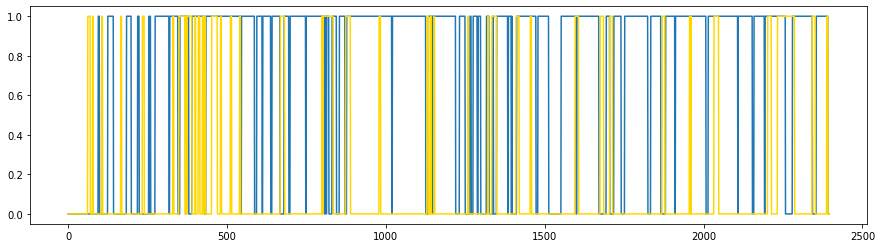

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
plt.plot(result.index, result['ADULT'])
plt.plot(result.index, result['CHILD'], color='gold')
plt.show()

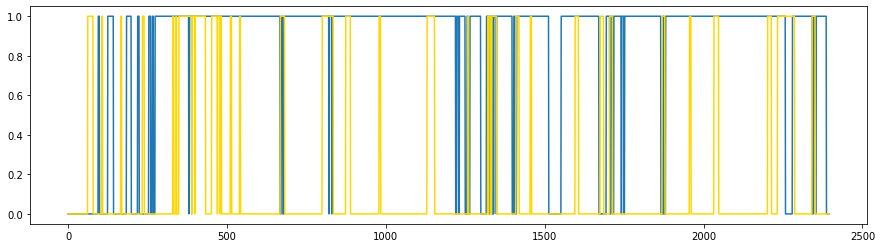

In [31]:
plt.figure(figsize=(15, 4))
plt.plot(result.index, result['SMOOTH_A'])
plt.plot(result.index, result['SMOOTH_C'], color='gold')
plt.show()

In [32]:
result.to_csv('./TestData/eNY-0287.csv')

## TeacherPrint Data

In [33]:
def convert(n): 
    return time.strftime("%M min %S sec", time.gmtime(n))

### Summary

In [34]:
# Calculate the total time (sec).
tp_time = round(len(result.index)*.1,1)
print("TOTAL LESSON TIME: " + convert(tp_time)) 

TOTAL LESSON TIME: 03 min 59 sec


### Talk Time
#### Raw

In [35]:
# Calculate total talktime (sec).
tp_tt = round(((result['ADULT'].sum() + result['CHILD'].sum())*.1), 1)
print("TOTAL TALK TIME: " + convert(tp_tt)) 

# Calculate teacher talktime (sec and %).
tp_ttt = round(result['ADULT'].sum()*.1, 1)
tp_ttt_pc = int(round((tp_ttt/tp_tt)*100, 0))
print(tp_ttt, tp_ttt_pc)

# Calculate student talktime (sec and %).
tp_stt = round(result['CHILD'].sum()*.1, 1)
tp_stt_pc = int(round((tp_stt/tp_tt)*100, 0))
print(tp_stt, tp_stt_pc)

print('During your lesson you spoke ' 
      + str(tp_ttt_pc) + '% of the time and the Students spoke ' 
      + str(tp_stt_pc) + '% of the time.')

# Calculate the Talk Time metric ("For every second...".
tp_tt_metric = int(round(tp_ttt/tp_stt, 0))
print('For every second of Student talk time, there were about ' 
      + str(tp_tt_metric) + ' seconds of Teacher talk time.')

TOTAL TALK TIME: 03 min 35 sec
180.3 84
34.9 16
During your lesson you spoke 84% of the time and the Students spoke 16% of the time.
For every second of Student talk time, there were about 5 seconds of Teacher talk time.


#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [36]:
# Calculate total smoothed talktime (sec).
tp_smtt = round(((result['SMOOTH_A'].sum() + result['SMOOTH_C'].sum())*.1), 1)
print("TOTAL TALK TIME: " + convert(tp_smtt)) 

# Calculate teacher talktime (sec and %).
tp_sttt = round(result['SMOOTH_A'].sum()*.1, 1)
tp_sttt_pc = int(round((tp_sttt/tp_smtt)*100, 0))
print(tp_sttt, tp_sttt_pc)

# Calculate student talktime (sec and %).
tp_sstt = round(result['SMOOTH_C'].sum()*.1, 1)
tp_sstt_pc = int(round((tp_sstt/tp_smtt)*100, 0))
print(tp_sstt, tp_sstt_pc)

print('During your lesson you spoke ' 
      + str(tp_sttt_pc) + '% of the time and the Students spoke ' 
      + str(tp_sstt_pc) + '% of the time.')

# Calculate the Talk Time metric ("For every second...".
tp_stt_metric = int(round(tp_sttt/tp_sstt, 0))
print('For every second of Student talk time, there were about ' 
      + str(tp_stt_metric) + ' seconds of Teacher talk time.')

TOTAL TALK TIME: 04 min 00 sec
198.5 83
41.9 17
During your lesson you spoke 83% of the time and the Students spoke 17% of the time.
For every second of Student talk time, there were about 5 seconds of Teacher talk time.


### Statements
#### Raw

In [37]:
#Calculate number of statements.
tp_utt_t = result['UTT_A'].value_counts()[1]
tp_utt_s = result['UTT_C'].value_counts()[1]
tp_utt = tp_utt_t + tp_utt_s
print(tp_utt, tp_utt_t, tp_utt_s)

# Calculate average statement length.
tp_uttlen_t = round((tp_ttt/tp_utt_t), 1)
print(tp_uttlen_t)
tp_uttlen_s = round((tp_stt/tp_utt_s), 1)
print(tp_uttlen_s)

print('Your average statement was ' 
      + str(tp_uttlen_t) + ' seconds long, while the average Student statement was ' 
      + str(tp_uttlen_s) + ' seconds long.')

93 52 41
3.5
0.9
Your average statement was 3.5 seconds long, while the average Student statement was 0.9 seconds long.


#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [38]:
#Calculate number of smoothed statements.
tp_sutt_t = result['SMOOTH_UTT_A'].value_counts()[1]
tp_sutt_s = result['SMOOTH_UTT_C'].value_counts()[1]
tp_sutt = tp_sutt_t + tp_sutt_s
print(tp_sutt, tp_sutt_t, tp_sutt_s)

# Calculate average smoothed statement length.
tp_suttlen_t = round((tp_ttt/tp_sutt_t), 1)
print(tp_suttlen_t)
tp_suttlen_s = round((tp_stt/tp_sutt_s), 1)
print(tp_suttlen_s)

print('Your average statement was ' 
      + str(tp_suttlen_t) + ' seconds long, while the average Student statement was ' 
      + str(tp_suttlen_s) + ' seconds long.')

69 35 34
5.2
1.0
Your average statement was 5.2 seconds long, while the average Student statement was 1.0 seconds long.


### Turns (Holding the Floor)
#### Raw

In [39]:
# Calculate teacher turns (sec and %).
tp_turn_t = round(result['TURN_A'].sum()*.1, 1)
tp_turn_t_pc = int(round((tp_turn_t/tp_tt)*100, 0))
print(tp_turn_t, tp_turn_t_pc)

# Calculate student turns (sec and %).
tp_turn_s = round(result['TURN_C'].sum()*.1, 1)
tp_turn_s_pc = int(round((tp_turn_s/tp_tt)*100, 0))
print(tp_turn_s, tp_turn_s_pc)

print('You held the floor for ' 
      + str(tp_turn_t_pc) + '% of the total talk time, while the Students held the floor for ' 
      + str(tp_turn_s_pc) + '% of the total talk time. Teacher and Students both spoke for the remainder of the time.')

160.6 75
15.2 7
You held the floor for 75% of the total talk time, while the Students held the floor for 7% of the total talk time. Teacher and Students both spoke for the remainder of the time.


#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [40]:
# Calculate teacher turns (sec and %).
tp_sturn_t = round(result['SMOOTH_TURN_A'].sum()*.1, 1)
tp_sturn_t_pc = int(round((tp_sturn_t/tp_smtt)*100, 0))
print(tp_sturn_t, tp_sturn_t_pc)

# Calculate student turns (sec and %).
tp_sturn_s = round(result['SMOOTH_TURN_C'].sum()*.1, 1)
tp_sturn_s_pc = int(round((tp_sturn_s/tp_smtt)*100, 0))
print(tp_sturn_s, tp_sturn_s_pc)

print('You held the floor for ' 
      + str(tp_sturn_t_pc) + '% of the total talk time, while the Students held the floor for ' 
      + str(tp_sturn_s_pc) + '% of the total talk time. Teacher and Students both spoke for the remainder of the time.')

166.4 69
9.8 4
You held the floor for 69% of the total talk time, while the Students held the floor for 4% of the total talk time. Teacher and Students both spoke for the remainder of the time.


### Overlaps

In [41]:
# Calculate overlap time (sec).
tp_ot = round(result['OVERLAP'].sum()*.1, 1)
print(tp_ot)

# Calculate smoothed overlap time (sec).
tp_sot = round(result['SMOOTH_OVERLAP'].sum()*.1, 1)
print(tp_sot)

19.7
32.1


### Pauses

In [42]:
# Calculate pause time (sec).
tp_pt = round(result['PAUSE'].sum()*.1, 1)
print(tp_pt)

# Calculate smoothed pause time (sec).
tp_spt = round(result['SMOOTH_PAUSE'].sum()*.1, 1)
print(tp_spt)

44.1
31.3


### Speaker Wheel
#### Raw

In [43]:
# Calculate Speaker Wheel input values (percent).
sw_adult = int(round((tp_ttt-tp_ot)/tp_time*100))
sw_overlap = int(round(tp_ot/tp_time*100))
sw_child = int(round((tp_stt-tp_ot)/tp_time*100))
sw_pause = int(round(tp_pt/tp_time*100))
sw_df = {"TEACHER": sw_adult, "OVERLAPS": sw_overlap, "STUDENT": sw_child, "PAUSES": sw_pause}
sw_df

{'TEACHER': 67, 'OVERLAPS': 8, 'STUDENT': 6, 'PAUSES': 18}

#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [44]:
# Calculate Speaker Wheel input values (percent) based on smoothed data.
ssw_adult = int(round((tp_sttt-tp_sot)/tp_time*100))
ssw_overlap = int(round(tp_sot/tp_time*100))
ssw_child = int(round((tp_sstt-tp_sot)/tp_time*100))
ssw_pause = int(round(tp_spt/tp_time*100))
ssw_df = {"TEACHER": sw_adult, "OVERLAPS": sw_overlap, "STUDENT": sw_child, "PAUSES": sw_pause}
ssw_df

{'TEACHER': 67, 'OVERLAPS': 8, 'STUDENT': 6, 'PAUSES': 18}